# CSC529 Assignment 2
## Matt Triano

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import warnings
from scipy import stats
from scipy.stats import t
from IPython.display import display
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import preprocessing
%matplotlib inline

In [3]:
# Loading the data set and splitting off the target feature, 'Class'
wine_df = pd.read_csv("wine.csv")
wine_class_df = wine_df['Class']
wine_data_df = wine_df.drop('Class', axis=1)
display(wine_df.columns)
wine_df.head(5)

Index(['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Mg',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Mg,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
# Generating a consistent set of random seeds, so that my results are reproducible
rng = np.random.RandomState(1234)
random_seeds = rng.randint(low=0, high=99999, size=30)
random_seeds

array([92975, 58067, 34086, 60620, 89460, 82584, 32399, 55985, 41239,
        9449, 23706,  8222, 97963, 33950, 40684,  8060, 73498, 79222,
       79728, 73180, 93509, 93520, 49398, 68094, 36271,  3824, 22267,
       21580, 80165, 77734])

In [5]:
# This function calculates the total accuracy of 2 classifiers, clf1 and clf2, 
#  on the same training and testing data, as well as the accuracy on the training
#  data (which gives the resubstitution (resub) error) and accuracy on the testing
#  data (which gives the generalization error).
# Takes 2 classifiers that conform to the sklearn classifier interface, strings
#  containing the names of the classifiers
# data_df:  an array-like object containing 
def clf_comparison(clf1, clf1_name, clf2, clf2_name, data_df, class_df,\
                   test_size=0.34, printStats=True, n_trials=30, seed=1234):
    rng = np.random.RandomState(seed)
    random_seeds = rng.randint(low=0, high=99999, size=n_trials)
    clf1_acc = [];       clf2_acc = []
    clf1_resub_acc = []; clf2_resub_acc = []
    clf1_gen_acc = [];   clf2_gen_acc = []
    for i in range(n_trials):
        data_train, data_test, class_train, class_test = \
                train_test_split(data_df, class_df, test_size=test_size, \
                                 random_state=random_seeds[i])
        clf1_acc.append(clf_evaluation(clf1, data_train, data_test, class_train, class_test))
        clf2_acc.append(clf_evaluation(clf2, data_train, data_test, class_train, class_test))
    clf1_resub, clf1_gen = resub_and_gen_errors(clf1, data_train, data_test, class_train, class_test)
    clf2_resub, clf2_gen = resub_and_gen_errors(clf2, data_train, data_test, class_train, class_test)
    clf1_resub_acc.append(clf1_resub)
    clf2_resub_acc.append(clf2_resub)
    clf1_gen_acc.append(clf1_gen)
    clf2_gen_acc.append(clf2_gen)
    mean_var_CI_calculator(clf1_name, pd.Series(clf1_acc), test_size, printStats)
    mean_var_CI_calculator(clf2_name, pd.Series(clf2_acc), test_size, printStats)
    mean_var_CI_calculator("Difference of " + clf1_name + " and " + clf2_name,
                           (pd.Series(clf1_acc)-pd.Series(clf2_acc)).abs(),0.34, printStats)
    return clf1_acc, clf2_acc, clf1_resub_acc, clf2_resub_acc, clf1_gen_acc, clf2_gen_acc
                        
# This executes a simple fit-predict-evaluate routine with a single data split.
# classifier:   a classifier model that conforms to sklearns regular classifier interface
# data/class_train/test: array-like containers holding corresponding data and class labels
def clf_evaluation(classifier, data_train, data_test, class_train, class_test):
    clf_fit = classifier.fit(data_train, class_train)
    clf_pred = classifier.predict(data_test)
    return accuracy_score(class_test, clf_pred)

# This takes a classifier and a spefi
def resub_and_gen_errors(classifier, data_train, data_test, class_train, class_test):
    classifier.fit(data_train, class_train)
    resub_err = classifier.score(data_train, class_train)
    gen_err = classifier.score(data_test, class_test)
    return resub_err, gen_err

# This calculates the mean accuracy, variance, and confidence interval and prints it
def mean_var_CI_calculator(clf_name, clf_acc, test_size, printStats=True):
    sample_mean = clf_acc.mean()
    sample_var = clf_acc.var()
    sample_std = clf_acc.std()
    sample_size = len(clf_acc)
    # we're using 30 data points, so it's fair to assume a normal distribution
    z_crit = stats.norm.ppf(0.975)  
    err_margin = z_crit * sample_std / (sample_size ** 0.5)
    if printStats:        
        print("Accuracy statistics For classifier: " + clf_name + " with "
          + str(test_size) + "% holdout for testing")
        print("- Sample Size: {:5d}".format(sample_size))
        print("- Variance: {:5f}".format(sample_var))
        print("- StdDev: {:5f}".format(sample_std))
        print("- Mean:{:>12.5f} +/- {:0.5f}".format(sample_mean, err_margin))
        print("- 95% CI =   [{:0.4f}, {:0.4f}]\n".format(sample_mean-err_margin,\
                                                         sample_mean+err_margin))

In [6]:
# Using the Decision Tree Classifier parameters found via a GridSearch
#   over 10 models and used for assignment 1
tree_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                            max_depth=3,
                                            min_samples_leaf=2,
                                            min_samples_split=2,
                                            random_state=1234)

nb_gauss_clf = naive_bayes.GaussianNB()

In [7]:
tree_acc, nb_gauss_acc, tree_resub_acc,\
nb_resub_acc, tree_gen_acc, nb_gen_acc = clf_comparison(tree_clf, "tree_clf",
                                                        nb_gauss_clf, "nb_gauss_clf",
                                                        wine_data_df, wine_class_df, 
                                                        0.34)

Accuracy statistics For classifier: tree_clf with 0.34% holdout for testing
- Sample Size:    30
- Variance: 0.000921
- StdDev: 0.030345
- Mean:     0.91421 +/- 0.01086
- 95% CI =   [0.9033, 0.9251]

Accuracy statistics For classifier: nb_gauss_clf with 0.34% holdout for testing
- Sample Size:    30
- Variance: 0.000229
- StdDev: 0.015129
- Mean:     0.96885 +/- 0.00541
- 95% CI =   [0.9634, 0.9743]

Accuracy statistics For classifier: Difference of tree_clf and nb_gauss_clf with 0.34% holdout for testing
- Sample Size:    30
- Variance: 0.000785
- StdDev: 0.028011
- Mean:     0.05464 +/- 0.01002
- 95% CI =   [0.0446, 0.0647]



The functions above used the same training and testing subsets to build a model for each classifier test the accuracy of both models. This process was repeated 30 times and the model accuracies were recorded to lists for their respective classifier. Then I calculated the above descriptive statistics for the both lists of accuracy values. 

To determine whether there's a statistically significant difference between the accuracies for these models, we'll perform a hypothesis test, and as we have 30 pairs (which is considered the lower bound for performing large-sample hypothesis tests) we'll perform a small-sample hypothesis test using Student's t-statistic. 

The small-sample hypothesis test for paired population means (ie the paired t-test) is given by the equation below

$$t = \frac{\bar{x}_d-D_0}{\frac{s_d}{\sqrt{n_d}}}$$

For our classifier accuracy data: 
* sample size $=n_d=30$ paired samples 
* sample mean difference        $\bar{x}_d = 0.05464$ 
* Sample Stdev of diffs         $s_d = 0.02801$
* Expected mean difference      $D_0$

The null hypothesis ($H_0$) is that the mean accuracy for models is the same, (ie $H_0:\mu_1 - \mu_2 = D_0 0$), and the alternative hypotheses is that the accuracies differ (ie $H_a:\mu_1 - \mu_2 \neq 0$).

$$t=\frac{(0.05464)-0}{\frac{0.02801}{\sqrt{30}}} = \frac{(0.05464)-0}{0.00511} = 10.6846$$

For $n=30$ and $\alpha = 0.025$ (two tailed $95%$), the critical t value is 2.042. The calculated 10.6846 is far outside those bounds, so the difference in model accuracy is statistically significant.

I also used the relative t-test evaluator in scipy's stats module, which calculated 10.6852, with a $p-val = 1.43 \times 10^{-11}$, which matches the calculated result.

In [8]:
paired_t = 0.05464/(0.02801/(30**0.5))
paired_t

10.684598551261077

In [9]:
stats.ttest_rel(nb_gauss_acc, tree_acc)

Ttest_relResult(statistic=10.685187333241123, pvalue=1.4369053553409192e-11)

# 2: Varying the Training-Testing Split

In [10]:
splits = [0.75, 0.65, 0.55, 0.45, 0.35, 0.25, 0.15]
tree_resub_acc_list = []; tree_gen_acc_list = []
nb_resub_acc_list = []; nb_gen_acc_list = []

for split in splits:
    tree_acc, nb_gauss_acc, tree_resub_acc, nb_resub_acc, tree_gen_acc, nb_gen_acc = \
            clf_comparison(tree_clf, "tree_clf", nb_gauss_clf, "nb_gauss_clf",
                           wine_data_df, wine_class_df, split, False)
    tree_resub_acc_list.extend(tree_resub_acc)
    tree_gen_acc_list.extend(tree_gen_acc)
    nb_resub_acc_list.extend(nb_resub_acc)
    nb_gen_acc_list.extend(nb_gen_acc)
    
resub_gen_dict = {'DTree Training Data Acc' : tree_resub_acc_list,
                  'DTree Testing Data Acc' : tree_gen_acc_list,
                  'NB Training Data Acc' : nb_resub_acc_list,
                  'NB Testing Data Acc' : nb_gen_acc_list}

resub_gen_df = pd.DataFrame(resub_gen_dict, index=splits)
resub_gen_error_df = 1-resub_gen_df
resub_gen_error_df.columns = ['DTree Resubstitution Error', 'DTree Generalization Error',
                              'NB Resubstitution Error', 'NB Generalization Error']
print('Classifier Accuracies indexed on Proportion of Data Heldout for Testing')
display(resub_gen_df)
print('Resubstitution and Generalization Error indexed on Proportion of Data Heldout for Testing')
display(resub_gen_error_df)

Classifier Accuracies indexed on Proportion of Data Heldout for Testing


,DTree Testing Data Acc,DTree Training Data Acc,NB Testing Data Acc,NB Training Data Acc
0.75,0.850746,0.977273,0.962687,1.000000
0.65,0.844828,0.967742,0.982759,1.000000
0.55,0.867347,0.987500,0.969388,1.000000
0.45,0.827160,0.989691,0.975309,1.000000
0.35,0.920635,0.982609,0.984127,0.991304
0.25,0.933333,0.984962,0.977778,0.992481
0.15,0.925926,0.986755,0.962963,0.993377


Resubstitution and Generalization Error indexed on Proportion of Data Heldout for Testing


,DTree Resubstitution Error,DTree Generalization Error,NB Resubstitution Error,NB Generalization Error
0.75,0.149254,0.022727,0.037313,0.000000
0.65,0.155172,0.032258,0.017241,0.000000
0.55,0.132653,0.012500,0.030612,0.000000
0.45,0.172840,0.010309,0.024691,0.000000
0.35,0.079365,0.017391,0.015873,0.008696
0.25,0.066667,0.015038,0.022222,0.007519
0.15,0.074074,0.013245,0.037037,0.006623


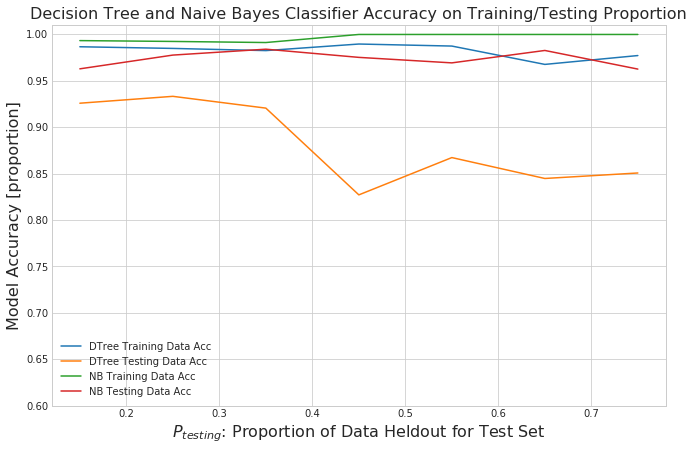

In [11]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(11,7))
    ax.plot(resub_gen_df.index, resub_gen_df['DTree Training Data Acc'])
    ax.plot(resub_gen_df.index, resub_gen_df['DTree Testing Data Acc'])
    ax.plot(resub_gen_df.index, resub_gen_df['NB Training Data Acc'])
    ax.plot(resub_gen_df.index, resub_gen_df['NB Testing Data Acc'])
    ax.legend(loc='lower left', frameon=False)
    ax.set_xlabel('$P_{testing}$: Proportion of Data Heldout for Test Set', fontsize=16)
    ax.set_ylabel('Model Accuracy [proportion]', fontsize=16)
    ax.set_ylim([0.6,1.01])
    ax.set_title('Decision Tree and Naive Bayes Classifier Accuracy' + 
                 ' on Training/Testing Proportion', fontsize=16)

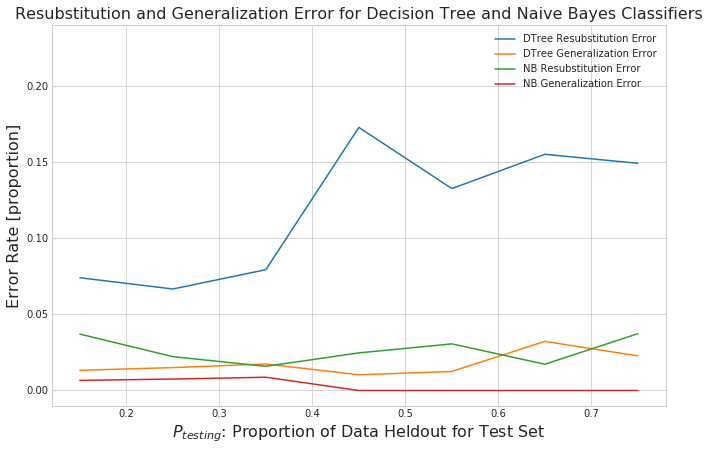

In [12]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(11,7))
    ax.plot(resub_gen_error_df.index, resub_gen_error_df['DTree Resubstitution Error'])
    ax.plot(resub_gen_error_df.index, resub_gen_error_df['DTree Generalization Error'])
    ax.plot(resub_gen_error_df.index, resub_gen_error_df['NB Resubstitution Error'])
    ax.plot(resub_gen_error_df.index, resub_gen_error_df['NB Generalization Error'])
    ax.legend(loc='upper right', frameon=False)
    ax.set_xlabel('$P_{testing}$: Proportion of Data Heldout for Test Set', fontsize=16)
    ax.set_ylabel('Error Rate [proportion]', fontsize=16)
    ax.set_ylim([-0.01,0.24])
    ax.set_title('Resubstitution and Generalization Error for' +\
                ' Decision Tree and Naive Bayes Classifiers', fontsize=16)

### Analysis of Results

From this analysis, we see that the generalization error ($Err_{gen}(P_{testing})$) for both the decision tree and naive Bayes classifiers was pretty low ($Err_{gen}<3.8\%$) for all examined training set sizes (which are given by $P_{training}=1-P_{testing}$). The naive Bayes classifier's resubstitution error was didn't vary substantially over the range of examined testing/training splits. The decision tree classifier's resubstitution error ($Err_{resub}$), however, was significantly impacted by decreasing the size of the training set, increasing from $Err_{resub}(15\%)\simeq7.4\%$ to $Err_{resub}(P_{testing})>13.2\%$ for all $P_{testing} > 0.45\%$. While there's not much utility to making a classifier that's exceptional at classifying training data, it is interesting that the generalization error remains so low.

These error rates were measured over 30 different selections of the testing and training subsets, so these are real effects and not artifacts of small sample sizes.

# 3: ROC and Lift Curves

ROC curves plot a classifier's True Positive Rate ($TPR$, aka sensitivity) and False Positive Rate ($FPR$, aka specificity) 

$$TPR = \frac{TP}{TP+FN} \quad \text{(Sensitivity)}$$

$$FPR = \frac{FP}{FP+TN} \quad \text{(Specificity)}$$

In [13]:
wine_df = pd.read_csv("wine.csv")
display(wine_df.columns)
display(wine_df.head(5))
print('Unique classes in the Wine data set: ' +str(wine_df.Class.unique()))
# Convert all instances of Class = 3 or Class = 2 to Class = 0
wine_df.Class.replace(3,0, inplace=True) 
wine_df.Class.replace(2,0, inplace=True)
print('Unique classes in the Wine data set after replacing 3 with 2: '
      +str(wine_df.Class.unique()))

Index(['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Mg',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Mg,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Unique classes in the Wine data set: [1 2 3]
Unique classes in the Wine data set after replacing 3 with 2: [1 0]


In [14]:
wine_class_df = wine_df['Class']
wine_data_df = wine_df.drop('Class', axis=1)
wine_train, wine_test, class_train, class_test = train_test_split(wine_data_df,
                                                                  wine_class_df,
                                                                  test_size=0.34,
                                                                  random_state=123)

# this handles a bug where the class arrays are given shape (n_rows,)
if(any(map(lambda x: x is None, class_train))):
    class_train = class_train.values.reshape((class_train.shape[0],1))

In [188]:
def confusion_mat_plotter(cfn_matrix, class_labels, title):
    print(cfn_matrix)
    sns.heatmap(cfn_matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('True Class')
    plt.ylabel('Predicted Class')
    plt.title('Confusion Matrix ' + title)

    
def ROC_plotter(true_vals, pred_probs, title='', pos=1):
    FPR, TPR, threshold = metrics.roc_curve(true_vals, pred_probs, pos_label=pos)
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(FPR, TPR)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([-0.01, 1.01])
        ax.set_ylim([-0.02, 1.02])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.set_title('ROC Curve: ' + title) 
#     print('threshold values: ' + str(threshold))

[[43  0]
 [ 0 18]]


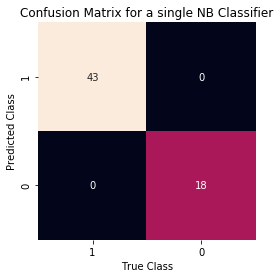

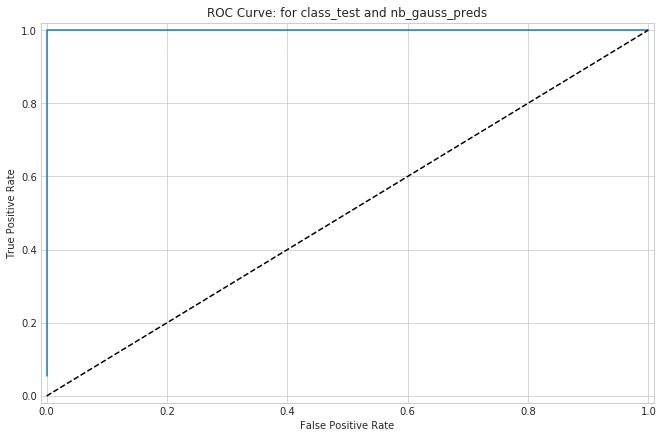

In [189]:
nb_gauss_clf = naive_bayes.GaussianNB()
nb_gauss_clf = nb_gauss_clf.fit(wine_train, class_train)
nb_gauss_preds = nb_gauss_clf.predict(wine_test)
confusion_mat = metrics.confusion_matrix(class_test, nb_gauss_preds)
confusion_mat_plotter(confusion_mat, [1,0], 'for a single NB Classifier')
# print(nb_gauss_preds) # for confirming the labels on the confusion matrix plot
# print(class_test)   # for confirming the labels on the confusion matrix plot

nb_pred_prob = nb_gauss_clf.predict_proba(wine_test)[:, 1]
ROC_plotter(class_test, nb_pred_prob, 'for class_test and nb_gauss_preds')

[[75  1]
 [ 2 39]]


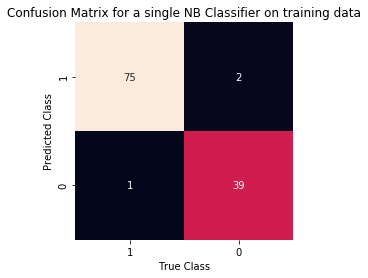

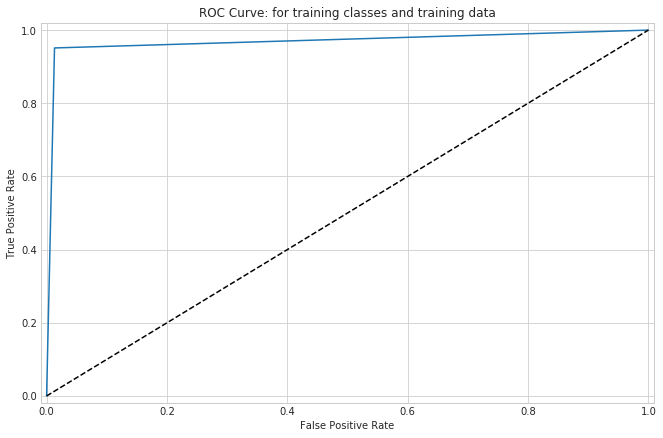

In [190]:
nb_gauss_clf = nb_gauss_clf.fit(wine_train, class_train)
nb_train_preds = nb_gauss_clf.predict(wine_train)
confusion_mat = metrics.confusion_matrix(class_train, nb_train_preds)
confusion_mat_plotter(confusion_mat, [1,0],
                      'for a single NB Classifier on training data')
ROC_plotter(class_train, nb_train_preds, 'for training classes and training data')
# display(nb_train_preds)
# display(class_train)

## 3b: 
These are boring results, as the classifier is producing perfect or nearly perfect predictions. Even for the relatively bad performance below (which I had to hunt for) had a $13.0\%$ specificity and a $96.8\%$ sensitivity. The knee in all of the ROC curves is very close to the upper left, so I would set a threshold of 0.95 for sensitivity and 0.05 for binary classification.

[[30  1]
 [ 3 20]]


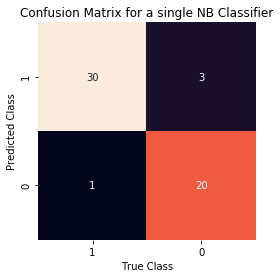

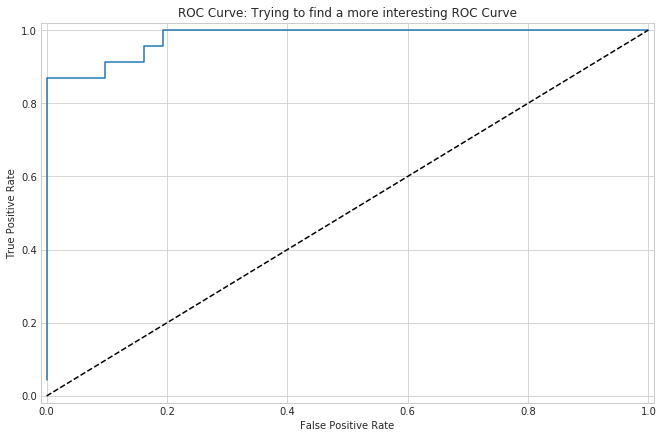

In [192]:
wine_train2, wine_test2, class_train2, class_test2 = train_test_split(wine_data_df,
                                                                      wine_class_df,
                                                                      test_size=0.30,
                                                                      random_state=5)
# this handles a bug where the class arrays are given shape (n_rows,)
if(any(map(lambda x: x is None, class_train2))):
    class_train2 = class_train2.values.reshape((class_train2.shape[0],1))

# class_train2.unique()
nb_gauss_clf2 = nb_gauss_clf.fit(wine_train2, class_train2)
nb_gauss_preds2 = nb_gauss_clf.predict(wine_test2)
nb_pred_prob = nb_gauss_clf.predict_proba(wine_test2)[:, 1]

confusion_mat2 = metrics.confusion_matrix(class_test2, nb_gauss_preds2)
confusion_mat_plotter(confusion_mat2, [1, 0], 'for a single NB Classifier')
ROC_plotter(class_test2, nb_pred_prob, 'Trying to find a more interesting ROC Curve')

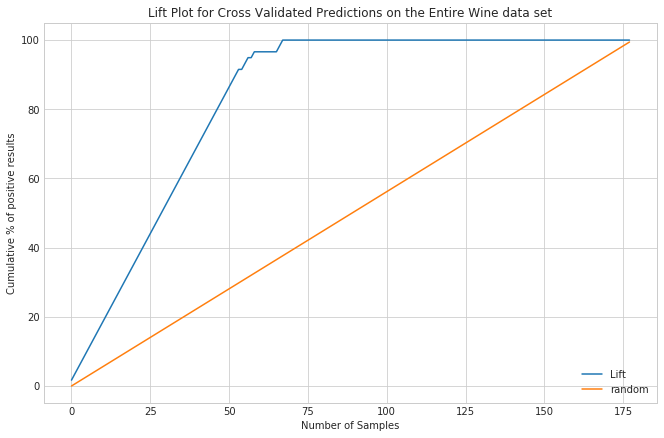

In [179]:
nb_cv_probs = cross_val_predict(nb_gauss_clf, wine_data_df, wine_class_df,\
                                cv=10, n_jobs=-1, method='predict_proba')
class_probs = pd.DataFrame({'Class_Label': wine_class_df,
                            'Prediction_Prob': nb_cv_probs[:,1]})
class_probs = class_probs.sort_values(by='Prediction_Prob', ascending=False)
class_probs.reset_index(drop=True, inplace=True)
class_probs['Lift'] = (100 * class_probs.Class_Label.cumsum()) / \
                        class_probs.Class_Label.sum()
class_probs['random'] = (100 / len(wine_class_df)) * class_probs.index
with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(class_probs.index, class_probs['Lift'])
        ax.plot(class_probs.index, class_probs['random'])
        ax.set_ylabel('Cumulative % of positive results')
        ax.set_xlabel('Number of Samples')
        ax.set_title('Lift Plot for Cross Validated Predictions on the Entire Wine data set')
        ax.legend(loc='lower right', frameon=False)

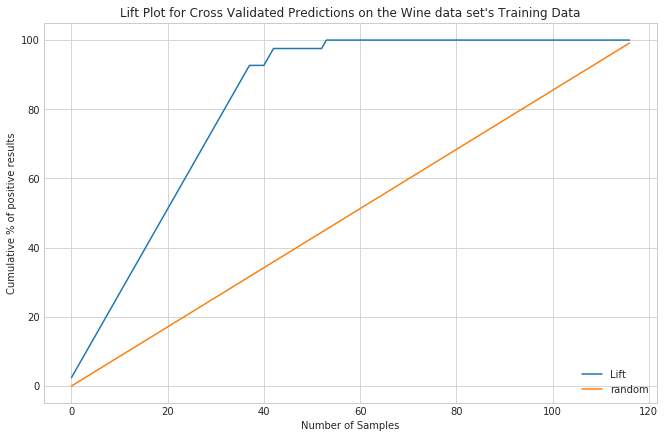

In [178]:
nb_cv_probs_tr = cross_val_predict(nb_gauss_clf, wine_train, class_train,
                                   cv=10, n_jobs=-1, method='predict_proba')
class_probs = pd.DataFrame({'Class_Label': class_train,
                            'Prediction_Prob': nb_cv_probs_tr[:,1]})
class_probs = class_probs.sort_values(by='Prediction_Prob', ascending=False)
class_probs.reset_index(drop=True, inplace=True)
class_probs['Lift'] = (100 * class_probs.Class_Label.cumsum()) / \
                        class_probs.Class_Label.sum()
class_probs['random'] = (100 / len(class_train)) * class_probs.index
with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(class_probs.index, class_probs['Lift'])
        ax.plot(class_probs.index, class_probs['random'])
        ax.set_ylabel('Cumulative % of positive results')
        ax.set_xlabel('Number of Samples')
        ax.set_title('Lift Plot for Cross Validated Predictions on'+
                     ' the Wine data set\'s Training Data')
        ax.legend(loc='lower right', frameon=False)

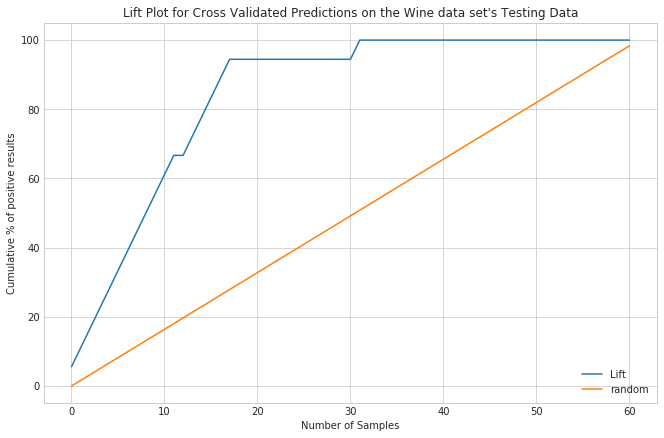

In [177]:
nb_cv_probs_te = cross_val_predict(nb_gauss_clf, wine_test, class_test,
                                   cv=10, n_jobs=-1, method='predict_proba')
class_probs = pd.DataFrame({'Class_Label': class_test,
                            'Prediction_Prob': nb_cv_probs_te[:,1]})
class_probs = class_probs.sort_values(by='Prediction_Prob', ascending=False)
class_probs.reset_index(drop=True, inplace=True)
class_probs['Lift'] = (100 * class_probs.Class_Label.cumsum()) / \
                        class_probs.Class_Label.sum()
class_probs['random'] = (100 / len(class_test)) * class_probs.index
with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(class_probs.index, class_probs['Lift'])
        ax.plot(class_probs.index, class_probs['random'])
        ax.set_ylabel('Cumulative % of positive results')
        ax.set_xlabel('Number of Samples')
        ax.set_title('Lift Plot for Cross Validated Predictions on'+
                     ' the Wine data set\'s Testing Data')
        ax.legend(loc='lower right', frameon=False)

## 3c analysis:

I realized after making the above plots that I was making gain curves, not lift curves. However, they still enable me to answer the question. To get at least a model accuracy of $80\%$, we should take roughly the top $25\%$ of samples, or the top

* $\simeq 30$ samples from the $117$ used in the training model,
* $\simeq 15$ samples from the $60$ used in the testing model, or
* $\simeq 45$ samples from the $177$ used in to make cross validated model based on all data. 

# 4: Ensemble methods

In [159]:
bc_df = pd.read_csv('wdbc.csv', index_col=0)
bc_class =bc_df.Diagnosis
bc_data = bc_df.drop('Diagnosis', axis=1)
display(bc_data.columns)
display(bc_df.head(3))
display(bc_data.head(3))
display(bc_class.head(3))

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'std_radius', 'std_texture', 'std_perimeter', 'std_area',
       'std_smoothness', 'std_compactness', 'std_concavity',
       'std_concave_points', 'std_symmetry', 'std_fractal_dimension',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension'],
      dtype='object')

,Diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
ID,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


ID
842302      M
842517      M
84300903    M
Name: Diagnosis, dtype: object

In [22]:
parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': list(range(1,10,2)),
    'min_samples_leaf': list(range(1,5,1)),
    'min_samples_split': list(range(2,10,1)),
    'max_features': list(range(5,30,5)),
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()
dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=1, cv=30, n_jobs=-1)

In [533]:
%time _ = dt_clf_gs.fit(bc_data, bc_class)

dt_clf_gs.best_params_, dt_clf_gs.best_score_

Fitting 30 folds for each of 1600 candidates, totalling 48000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3905 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 12905 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 25505 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 41705 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 48000 out of 48000 | elapsed:  1.1min finished


Wall time: 1min 9s


({'criterion': 'entropy',
  'max_depth': 5,
  'max_features': 15,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'random_state': 123},
 0.96485061511423553)

In [534]:
dt_clf_gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=15, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [23]:
dt_clf_best = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                         max_features=15, min_samples_leaf=1,
                                         min_samples_split=2, random_state=123)

In [142]:
dt_clf_bag = BaggingClassifier(base_estimator=dt_clf_best,
                               n_estimators=1,
                               max_samples=0.66,
                              random_state=123,
                              n_jobs=-1)

[[115   1]
 [  4  74]]


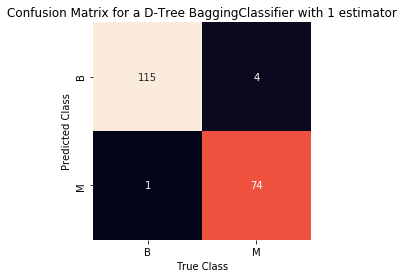

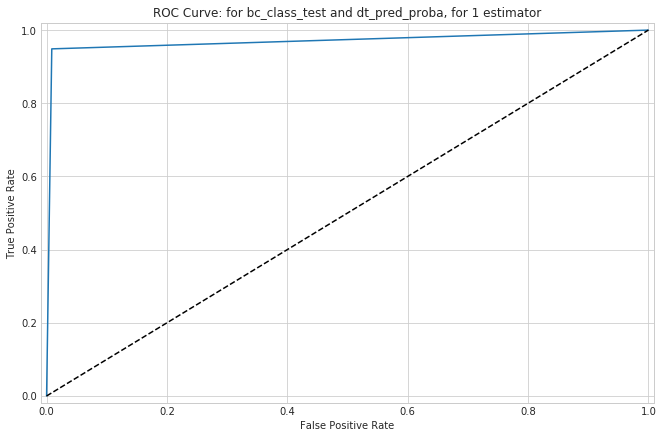

In [144]:
bc_data_train, bc_data_test, bc_class_train, bc_class_test = \
                                        train_test_split(bc_data,
                                                         bc_class,
                                                         test_size=0.34,
                                                         random_state=123)
dt_clf_bag.fit(bc_data_train, bc_class_train)
dt_bag_pred = dt_clf_bag.predict(bc_data_test)
accuracy_score(bc_class_test, dt_bag_pred)
cfn_mat_bag = metrics.confusion_matrix(bc_class_test, dt_bag_pred)
confusion_mat_plotter(cfn_mat_bag, ['B', 'M'], 
                      'for a D-Tree BaggingClassifier with 1 estimator')
dt_pred_proba = dt_clf_bag.predict_proba(bc_data_test)[:, 1]
ROC_plotter(bc_class_test, dt_pred_proba,
            'for bc_class_test and dt_pred_proba, for 1 estimator','M')

In [83]:
# Confirming labels
n_m = 0
n_b = 0
for s in bc_class_test:
    if s == 'M':
        n_m = n_m + 1
    elif s == 'B':
        n_b = n_b + 1
print('n_m: ' + str(n_m))
print('n_b: ' + str(n_b))

n_m: 78
n_b: 116


In [36]:
result = cross_val_score(dt_clf_bag, bc_data, bc_class, cv=10)
result

array([ 0.98275862,  0.9137931 ,  0.92982456,  0.94736842,  1.        ,
        0.98245614,  0.96491228,  0.98214286,  0.96428571,  1.        ])

In [145]:
# Builds an ensemble of decision trees through bagging and calculates accuracy.
# base_clf:            a base classifier to use. 
# data/classes:        the data and class labels to use in clf building.
# n_estimators_list:   a list of ints. The numbers of estimators to use.
# samples:             the max proportion of data to use for training.
# seed:                a seed number for random_state.
# verbose:             turns on printing. This function can take a long time.
def baggingClfScan(base_clf, data, classes, n_estimators_list,\
                   samples=0.66, seed=123, verbose=False):
    acc_results = dict.fromkeys(n_estimators_list)
    for n_est in n_estimators_list:
        if (verbose):
            print('currently evaluating model with '+str(n_est)+ ' estimators')
        bag_clf = BaggingClassifier(base_estimator=base_clf,
                                    n_estimators=n_est,
                                    max_samples=samples,
                                    random_state=seed,
                                    n_jobs=-1)
        acc_results[n_est] = cross_val_score(bag_clf, data, bc_class, cv=10)
        if (verbose):
            print('Accuracy score for the bagging clf with '+str(n_est)+' estimators')
            print(str(acc_results[n_est].mean()))
    return results

In [65]:
# print statements were included as this took a long time to run. 
# ~ 11 minutes for this list of 
n_ests = [1,5,25,50,100,150,200,250,300,350,400,450,500]
bagg_results = baggingClfScan(dt_clf_best, bc_data, bc_class, n_ests, 0.66, 123, True)   

currently evaluating model with 1 estimators
Accuracy score for the bagging clf with 1 estimators
0.915869414917
currently evaluating model with 5 estimators
Accuracy score for the bagging clf with 5 estimators
0.944067064212
currently evaluating model with 25 estimators
Accuracy score for the bagging clf with 25 estimators
0.95985869847
currently evaluating model with 50 estimators
Accuracy score for the bagging clf with 50 estimators
0.959797122116
currently evaluating model with 100 estimators
Accuracy score for the bagging clf with 100 estimators
0.963275646012
currently evaluating model with 150 estimators
Accuracy score for the bagging clf with 150 estimators
0.96152017976
currently evaluating model with 200 estimators
Accuracy score for the bagging clf with 200 estimators
0.963244317691
currently evaluating model with 250 estimators
Accuracy score for the bagging clf with 250 estimators
0.964968455622
currently evaluating model with 300 estimators
Accuracy score for the bagging 

In [130]:
# reformatting the results for plotting
bagg_vals = sorted(bagg_results.items())
bagg_nest, bagg_accs = zip(*bagg_vals)
bagg_mean_accs = np.array(bagg_accs).mean(axis=1)
bagg_mean_errs = 1 - bagg_mean_accs
display(bagg_nest)
display(bagg_mean_accs)
display(bagg_mean_errs)

(1, 5, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500)

array([ 0.91586941,  0.94406706,  0.9598587 ,  0.95979712,  0.96327565,
        0.96152018,  0.96324432,  0.96496846,  0.96496846,  0.96496846,
        0.96496846,  0.96496846,  0.96496846])

array([ 0.08413059,  0.05593294,  0.0401413 ,  0.04020288,  0.03672435,
        0.03847982,  0.03675568,  0.03503154,  0.03503154,  0.03503154,
        0.03503154,  0.03503154,  0.03503154])

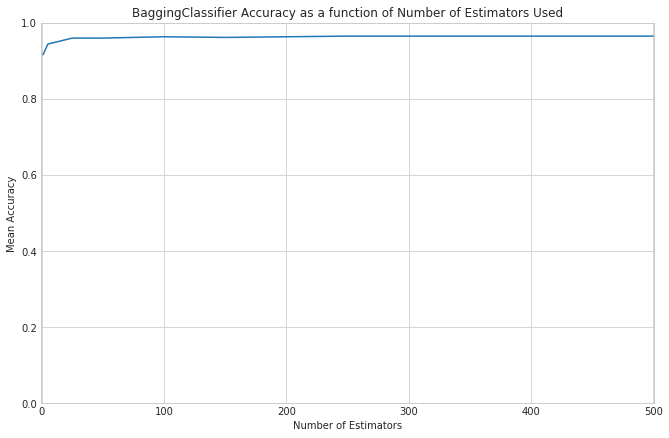

In [120]:
with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(bagg_nest, bagg_mean_accs)
        ax.set_xlim([-1, 501])
        ax.set_ylim([0.0, 1.00])
        ax.set_ylabel('Mean Accuracy')
        ax.set_xlabel('Number of Estimators')
        ax.set_title('BaggingClassifier Accuracy as a function of Number of Estimators Used')

We see that the accuracy is always fairly high and levels out quickly. Let's zoom in on the low end, and adjust the y-scale to highlight that change.

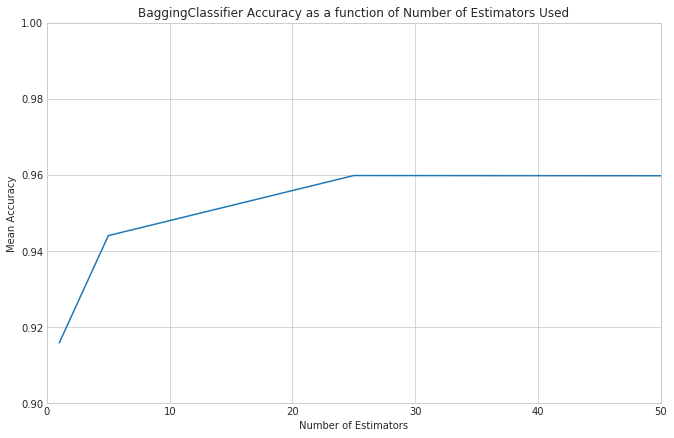

In [167]:
with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(bagg_nest, bagg_mean_accs)
        ax.set_xlim([0, 50])
        ax.set_ylim([0.90, 1.00])
        ax.set_ylabel('Mean Accuracy')
        ax.set_xlabel('Number of Estimators')
        ax.set_title('BaggingClassifier Accuracy as a function of Number of Estimators Used')

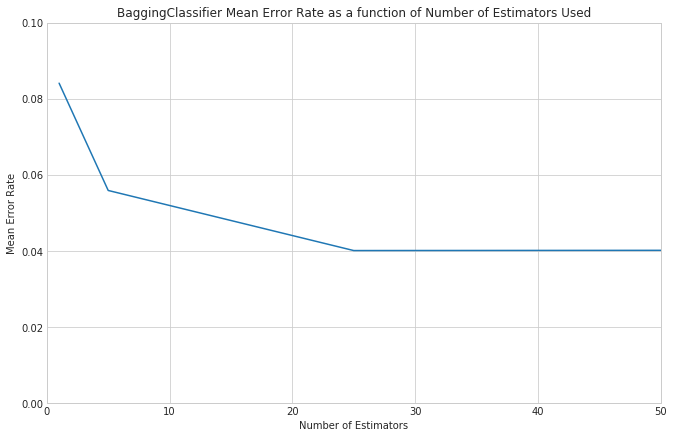

In [131]:
with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(bagg_nest, bagg_mean_errs)
        ax.set_xlim([0, 50])
        ax.set_ylim([0.0, 0.10])
        ax.set_ylabel('Mean Error Rate')
        ax.set_xlabel('Number of Estimators')
        ax.set_title('BaggingClassifier Mean Error Rate as a function of Number of Estimators Used')

From these zoomed in plots, we see the best mean accuracy and error rates are reached when the number of estimators reaches 25, at which point there are no changes to accuracy. As we can see from the confusion matrix and ROC curve below, using 25 estimators produced a model with a slightly greater sensitivity than the earlier model that used 1 estimator.

0.98453608247422686

[[115   1]
 [  2  76]]


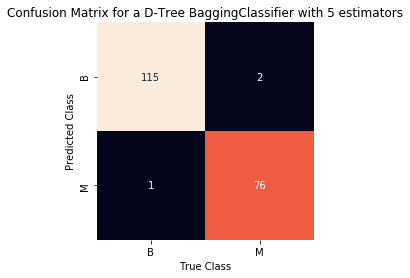

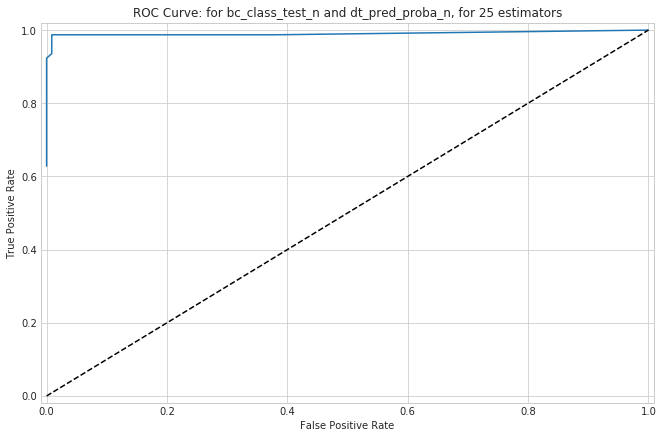

In [141]:
dt_clf_bag_n = BaggingClassifier(base_estimator=dt_clf_best,
                                    n_estimators=25,
                                    max_samples=0.66,
                                    random_state=123,
                                    n_jobs=-1)
bc_data_train_n, bc_data_test_n, bc_class_train_n, bc_class_test_n = \
                                        train_test_split(bc_data,
                                                         bc_class,
                                                         test_size=0.34,
                                                         random_state=123)
dt_clf_bag_n.fit(bc_data_train_n, bc_class_train_n)
dt_bag_pred_n = dt_clf_bag_n.predict(bc_data_test_n)
display(accuracy_score(bc_class_test_n, dt_bag_pred_n))
cfn_mat_bag_n = metrics.confusion_matrix(bc_class_test_n, dt_bag_pred_n)
confusion_mat_plotter(cfn_mat_bag_n, ['B', 'M'], 
                      'for a D-Tree BaggingClassifier with 5 estimators')
dt_pred_proba_n = dt_clf_bag_n.predict_proba(bc_data_test_n)[:, 1]
ROC_plotter(bc_class_test_n, dt_pred_proba_n,
            'for bc_class_test_n and dt_pred_proba_n, for 25 estimators','M')

## 4b: Bagging Appropriateness

In my code above, I used varying numbers of decision tree classifiers to build bagging classifiers, and I used crossvalidated these bagged classifiers at each level. The accuracy values produced are the averaged vote of 10 to 250 individual decision trees (and also to 5000, but bagging more than 25 classifiers didn't substantially improve accuracy), and by increasing the number of classifiers bagged, the observed accuracy values increased from just undere $91\%$ to just under $96\%$. That shows that bagging is appropriate for this data, and that decision trees are a reasonably good classifier to use for this data set, which has 30 different features (although the cost of a false negative or (to a slightly lesser degree) a false positive is extremely high in this case).

Additionally, decision trees are one of the best classifier to use with bagging as bagging works best on unstable nonlinear models. Decision trees are notorious for overfitting to training data, which is another way of saying that they are unstable and a small change in training data can produce a significantly different classifier. 

## 4c: Bagging vs Boosting

Bagging algorithms produce many parallel models trained on different subsets of all of the date and aggregates the predictions of those models into 1 set of probabilities. This minimizes the impact that any outlier model or non-representative training subset has on the whole prediction. Bagging is appropriate for use with unstable learners (described in **4b**). 

Boosting algorithms take single weak learner classifiers (ie slightly better than random) and iteratively improves the same model by looking at the misclassifications and adjusting the weighting of different data features to avoid making the same misclassifications. Boosting is vulnerable to outliers and can quickly be confused by complex classifiers and systems, but it's very simple to implement.

In [ ]:
# help(metrics.roc_curve)
# help(RandomizedSearchCV)
# help(pd.DataFrame.replace)
# help(metrics.confusion_matrix)
# help(naive_bayes.GaussianNB.predict_proba)
# help(BaggingClassifier)